In [1]:
import sys
sys.path.append('../../')

from dl.data.txtdetn import datasets, utils, target_transforms, augmentations
from dl.data import transforms
from dl.models.fots import FOTSRes50
from dl.loss.fots import FOTSLoss

from dl.optim.scheduler import IterMultiStepLR
from dl.log import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam

import numpy as np
%matplotlib notebook

In [2]:
augmentation = augmentations.Compose([
        augmentations.RandomLongerResize(smin=640, smax=2560),
        augmentations.RandomRotate(fill_rgb=(103.939, 116,779, 123.68), amin=-10, amax=10, same=True),
        augmentations.RandomScaleV(smin=0.8, smax=1.2, keep_aspect=True),
        augmentations.RandomSimpleCrop()
    ])

ignore = target_transforms.Ignore(strange=True)

transform = transforms.Compose(
    [transforms.Resize((640, 640)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Text2Number(class_labels=datasets.SynthText_char_labels_without_upper_blank, ignore_nolabel=False),
     target_transforms.ToTensor(textTensor=True)]
)

train_dataset = datasets.SynthTextDetectionDataset(ignore=ignore, transform=transform, target_transform=target_transform, augmentation=augmentation,
                                                   onlyAlphaNumeric=False)

train_loader = DataLoader(train_dataset,
                          batch_size=8,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)

model = FOTSRes50(chars=datasets.SynthText_char_labels_without_upper_blank, input_shape=(None, None, 3)).cuda()
print(model)


160 is from 640/4


FOTSRes50(
  (feature_extractor): SharedConvRes50(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (res2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

INFO:root:Created directory: /home/kado/weights/fots-pretrain
INFO:root:Created directory: /home/kado/weights/fots-pretrain/checkpoints


<IPython.core.display.Javascript object>


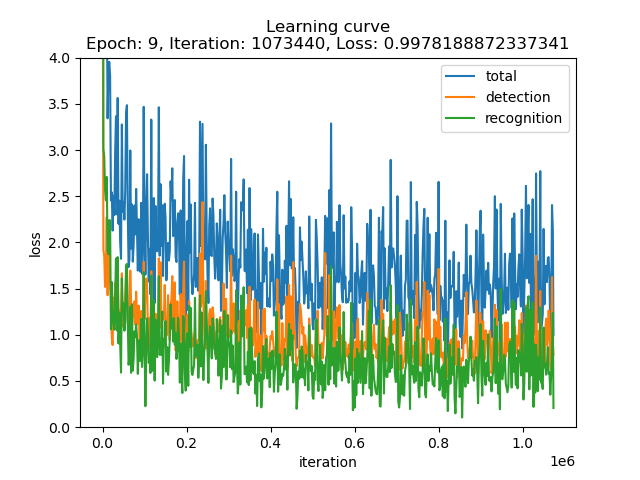

Training... Epoch: 0, Iter: 107344,	 0%[0/107344]	total: 2.115015 detection: 1.040357 recognition: 1.074658 	Iter time: 0.3919 0.5327
Saved model to /home/kado/weights/fots-pretrain/checkpoints/i-0107344_checkpoints20200914.pth

Training... Epoch: 1, Iter: 214688,	 0%[0/107344]	total: 2.561705 detection: 1.157420 recognition: 1.404285 	Iter time: 0.3705 0.5335
Saved model to /home/kado/weights/fots-pretrain/checkpoints/i-0214688_checkpoints20200914.pth

Training... Epoch: 2, Iter: 322032,	 0%[0/107344]	total: 0.827815 detection: 0.586864 recognition: 0.240950 	Iter time: 0.3426 0.4909
Saved model to /home/kado/weights/fots-pretrain/checkpoints/i-0322032_checkpoints20200914.pth

Training... Epoch: 3, Iter: 429376,	 0%[0/107344]	total: 1.860181 detection: 1.113179 recognition: 0.747002 	Iter time: 0.3859 0.5398
Saved model to /home/kado/weights/fots-pretrain/checkpoints/i-0429376_checkpoints20200914.pth

Training... Epoch: 4, Iter: 536720,	 0%[0/107344]	total: 0.991912 detection: 0.51693

INFO:root:Saved model to /home/kado/weights/fots-pretrain/fots-pretrain_model_i-1073440.pth


INFO:root:Saved optimizer to /home/kado/weights/fots-pretrain/fots-pretrain_optimizer_i-1073440.pth
INFO:root:Saved scheduler to /home/kado/weights/fots-pretrain/fots-pretrain_scheduler_i-1073440.pth


<IPython.core.display.Javascript object>


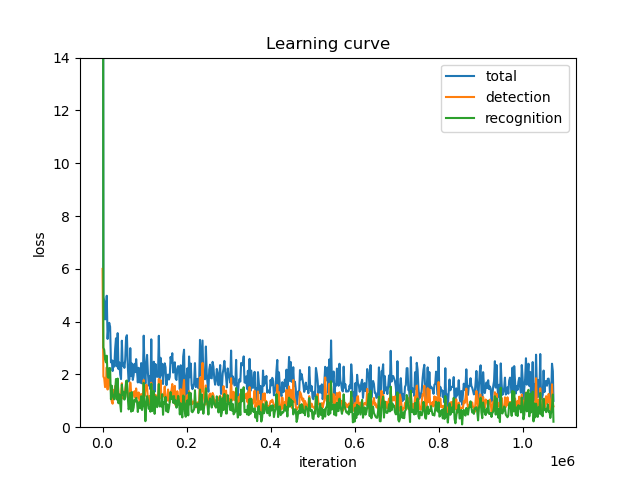

Saved graph to /home/kado/weights/fots-pretrain/fots-pretrain_learning-curve_i-1073440.png


In [3]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
iter_sheduler = iter_sheduler = IterMultiStepLR(optimizer, milestones=np.arange(10000, 107344*10, 10000), gamma=0.94, verbose=False)


save_manager = SaveManager(modelname='fots-pretrain', interval=107344, max_checkpoints=10, plot_interval=2000)

trainer = TrainTextSpottingJupyterLogger(LiveGraph(yrange=(0, 4)), FOTSLoss(), model, optimizer, scheduler=iter_sheduler)#iter_sheduler)
#trainer.train_epoch(save_manager, 10, train_loader)
trainer.train_iter(save_manager, 1073440, train_loader)